# Implement Linear Regresssion using housing dataset 

In [1]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

In [2]:
train = pd.read_csv("./input/train.csv")

### As part of the task we need to train the model to predict the saleprice of the house based on Area of the house, Number of bedrooms and Number of bathrooms.
#### In this dataset there are many other features apart from the required so we have used all the features in this LinearRegression model for better quality model.
#### The required features are
1. 'LotArea' - The area of the plot 
2. 'FullBath' - Number of full bathrooms in the house
3. 'HalfBath' - Number of half baths in the house
4. 'BedroomAbvGr' - Number of bedrooms above ground in the house

In [3]:
print(f'No. of (records, columns) in train dataset: ({len(train.index)},{len(train.columns)})')

No. of (records, columns) in train dataset: (1460,81)


In [4]:
print ('Total missing values in train set', sum(train.isna().sum()))

Total missing values in train set 6965


### We are going to get the most correlated columns and remove outliers for better performance of the model because outliers can hinder the performance and damage the model.

In [5]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

Text(0.5, 0, 'GrLivArea (Above "ground" living area square feet)')

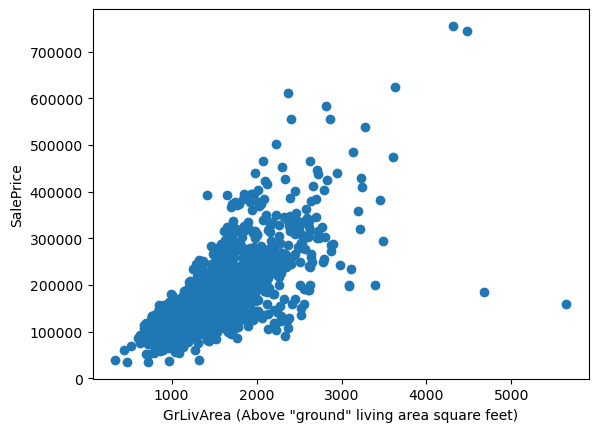

In [6]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above "ground" living area square feet)')

Text(0.5, 0, 'GarageArea')

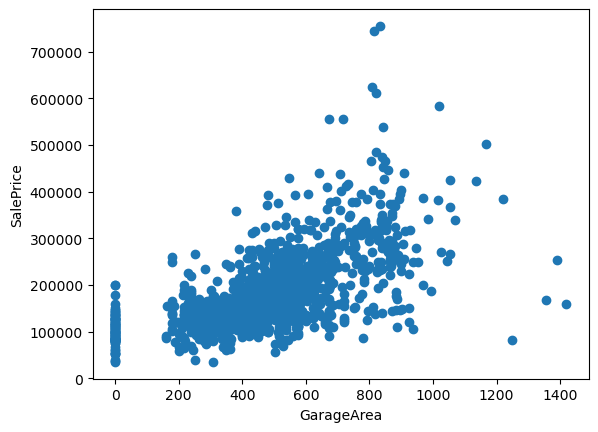

In [7]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

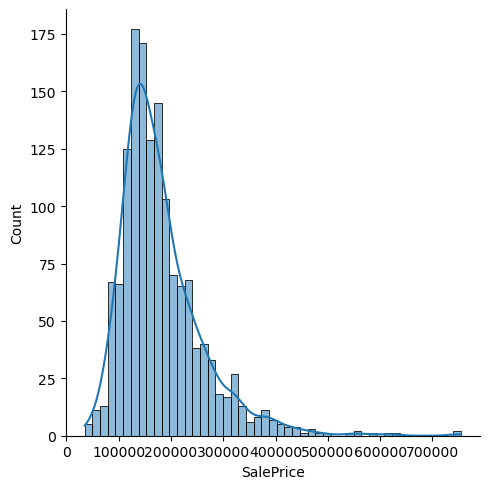

In [8]:
sns.displot(train['SalePrice'],kde=True)
plt.show()

### We can see in the above graph that the data is skewed to the left and this might hinder the performance of the regression model so we try to remove skewness and make it into normal distribution using logarithmic conversion.

In [9]:
# remove outliers
train = train[train['GrLivArea'] < 4500]
train = train[train['GarageArea'] < 1200]
# drop columns with percentage of missing values > 80% in train and test data.
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


### Since we can't send categorical values to the linear regression we convert the values to numericals using LabelEncoder() in scikit-learn

In [10]:
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [11]:
# fill missing values based on probability of occurrence in train
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [12]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [13]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## LinearRegression model

In [14]:
lr = linear_model.LinearRegression()

In [15]:
model = lr.fit(X_train, y_train)

In [16]:
predictions = model.predict(X_test)

In [17]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.08671211531268641
MSE is: 0.01661642297285022
RMSE is: 0.1289047050066452


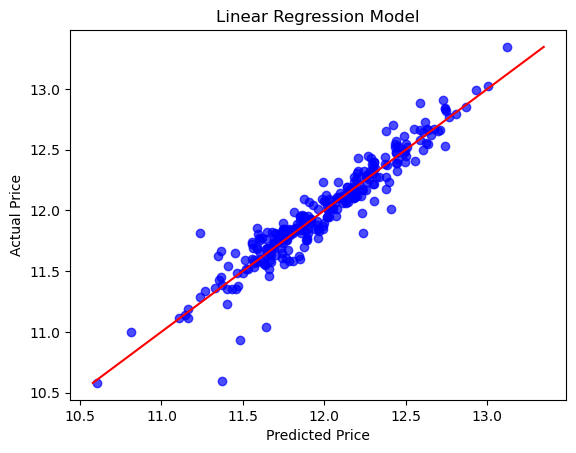

In [18]:
# Visualize the linear regression model and overlay the regression line.
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()